In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact
from scipy.optimize import minimize
from itertools import combinations 

In [2]:
#Importo market data del portafolio

data = pd.read_excel("PreciosPortf.xlsx", index_col=0)
data

,ASURB MF Equity,GFNORTEO MF Equity,PE&OLES* MF Equity,WALMEX* MF Equity,IENOVA* MF Equity
DATE,,,,,
2016-01-01,243.89,94.99,177.22,43.49,72.34
2016-01-04,238.29,91.79,175.90,42.84,72.98
2016-01-05,233.03,91.72,176.45,42.66,71.48
2016-01-06,231.97,91.63,172.68,42.38,70.94
2016-01-07,230.71,89.54,172.94,39.99,72.31
...,...,...,...,...,...
2019-12-30,354.06,105.00,200.37,54.18,86.96
2019-12-31,354.04,105.65,198.21,54.15,88.93
2020-01-01,354.04,105.65,198.21,54.15,88.93


In [3]:
data.shape  #veo la dimension de mi informacion

(1046, 5)

In [4]:
#Genero matriz de rendimeintos
rend = data.pct_change().dropna() #limpio los registros en donde exista un NA
rend

,ASURB MF Equity,GFNORTEO MF Equity,PE&OLES* MF Equity,WALMEX* MF Equity,IENOVA* MF Equity
DATE,,,,,
2016-01-04,-0.022961,-0.033688,-0.007448,-0.014946,0.008847
2016-01-05,-0.022074,-0.000763,0.003127,-0.004202,-0.020554
2016-01-06,-0.004549,-0.000981,-0.021366,-0.006564,-0.007555
2016-01-07,-0.005432,-0.022809,0.001506,-0.056395,0.019312
2016-01-08,-0.004118,-0.007706,-0.003180,0.026007,-0.017148
...,...,...,...,...,...
2019-12-30,-0.005868,-0.035990,0.004562,-0.026240,-0.008777
2019-12-31,-0.000056,0.006190,-0.010780,-0.000554,0.022654
2020-01-01,0.000000,0.000000,0.000000,0.000000,0.000000


In [5]:
rend.shape

(1045, 5)

In [6]:
#Generamos un base en donde solo conservemos el ticker del instrumento y generamos la matriz de rendimientos
columnas2 = []
for c in data.columns:
    columnas2.append(c.replace(" MF Equity",""))

data.columns = columnas2
rend.columns = columnas2

In [7]:
data.head()

,ASURB,GFNORTEO,PE&OLES*,WALMEX*,IENOVA*
DATE,,,,,
2016-01-01,243.89,94.99,177.22,43.49,72.34
2016-01-04,238.29,91.79,175.90,42.84,72.98
2016-01-05,233.03,91.72,176.45,42.66,71.48
2016-01-06,231.97,91.63,172.68,42.38,70.94
2016-01-07,230.71,89.54,172.94,39.99,72.31


In [8]:
rend.head()

,ASURB,GFNORTEO,PE&OLES*,WALMEX*,IENOVA*
DATE,,,,,
2016-01-04,-0.022961,-0.033688,-0.007448,-0.014946,0.008847
2016-01-05,-0.022074,-0.000763,0.003127,-0.004202,-0.020554
2016-01-06,-0.004549,-0.000981,-0.021366,-0.006564,-0.007555
2016-01-07,-0.005432,-0.022809,0.001506,-0.056395,0.019312
2016-01-08,-0.004118,-0.007706,-0.003180,0.026007,-0.017148


In [9]:
#Genero vector de rendimiento promedio anualizado del portafolio por emisora
rend_ports = rend.mean()*252
rend_ports

ASURB       0.123539
GFNORTEO    0.078811
PE&OLES*    0.111053
WALMEX*     0.082426
IENOVA*     0.078997
dtype: float64

In [10]:
#funciones para el calculo del rendimiento (port_rend) y volatilidad (port_vol)

def port_rend(weights,r): #r es la matriz de rendimientos
    E_p = (rend.mean() * weights).sum()*252
    return E_p

def port_vol(weights,r): #r es la matriz de rendimientos
    S_p = np.sqrt(weights.T @ (r.cov()*252)@weights)
    return S_p

In [11]:
#genero pesos simulados para el portafolio (genero distintos escenarios)
weights_sim = np.random.random((5000,5)) #numero de portafolios a simular x numero de acciones en el portafiolio
weights_sim = weights_sim / weights_sim.sum(axis=1,keepdims=True) #los dejo entre 0 y 1
weights_sim

array([[0.25686991, 0.2999792 , 0.19220485, 0.18461644, 0.06632961],
       [0.26897906, 0.0733633 , 0.27003423, 0.22162526, 0.16599815],
       [0.16742069, 0.00251653, 0.38945285, 0.0776404 , 0.36296954],
       ...,
       [0.15406555, 0.20107601, 0.19448898, 0.18444908, 0.26592037],
       [0.14669043, 0.28989438, 0.09786904, 0.34196074, 0.12358541],
       [0.19836887, 0.1692518 , 0.22445231, 0.12063733, 0.28728968]])

In [12]:
weights_sim.shape #tengo 500 escenarios de distintos pesos

(5000, 5)

In [13]:
#todos los pesos suman 1, 5000 en total
sum(weights_sim.sum(axis=1))

5000.0

In [14]:
rend_sim = np.apply_along_axis(port_rend,1,weights_sim,r=rend)
vol_sim = np.apply_along_axis(port_vol,1,weights_sim,r=rend)
print(rend_sim)
print(vol_sim)

[0.09717726 0.10038055 0.09920451 ... 0.09268914 0.08978693 0.09541015]
[0.17853334 0.17071655 0.19613059 ... 0.16776261 0.17132628 0.17044106]


In [15]:
print(rend_sim.shape)
print(vol_sim.shape)

(5000,)
(5000,)


In [16]:
#Genero un vector que contenga el sharpe ratio para cada escenario simulado
sharpe_ratio = rend_sim / vol_sim
sharpe_ratio

array([0.54430877, 0.58799543, 0.50580844, ..., 0.5525018 , 0.52406981,
       0.5597838 ])

In [17]:
sharpe_ratio.shape

(5000,)

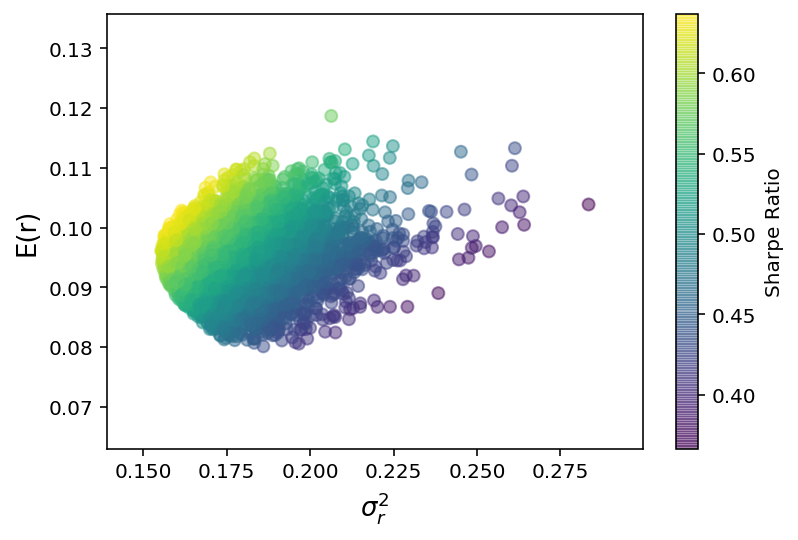

In [18]:
#Grafic0 el conjunto de portafolio simulados en fucion de su rendimiento y volatilidad
%config InlineBackend.figure_format='retina'
plt.scatter(vol_sim,rend_sim, c=sharpe_ratio,alpha=.5)
plt.colorbar(label="Sharpe Ratio",)
plt.xlabel(r"$\sigma^2_r$", fontsize=13)
plt.ylabel("E(r)",fontsize=13);

In [19]:
#definimos las funciones de contraints de la optimizaciòn

def sum_weights(weights):
    return weights.sum()-1

def rend_esperado(weights, E):
    return port_rend(weights, rend) - E

def allocate(weights,i,j):
    w1 = weights[i]
    w2 = weights[j]
    return -(w1+w2) + .90

def min_per(weights,i):
    return weights[i] -.30

def max_per(weights,i):
    return weights[i] +.25


def neg_weigts(weights):
    return min(weights) #sin ventas en corto

In [20]:
#defino rango sobre el cual podamos genrar la frontera, tomando como lìmites los rendimeintos mínimos y máximos del portafolio inicial
rmin = rend_ports.min()
rmax = rend_ports.max()
rend_maxs = np.linspace(rmin,rmax)
rend_maxs

array([0.07881127, 0.07972409, 0.08063691, 0.08154972, 0.08246254,
       0.08337536, 0.08428817, 0.08520099, 0.0861138 , 0.08702662,
       0.08793944, 0.08885225, 0.08976507, 0.09067789, 0.0915907 ,
       0.09250352, 0.09341633, 0.09432915, 0.09524197, 0.09615478,
       0.0970676 , 0.09798041, 0.09889323, 0.09980605, 0.10071886,
       0.10163168, 0.1025445 , 0.10345731, 0.10437013, 0.10528294,
       0.10619576, 0.10710858, 0.10802139, 0.10893421, 0.10984702,
       0.11075984, 0.11167266, 0.11258547, 0.11349829, 0.11441111,
       0.11532392, 0.11623674, 0.11714955, 0.11806237, 0.11897519,
       0.119888  , 0.12080082, 0.12171364, 0.12262645, 0.12353927])

In [21]:
#Vamos a generar la frontera eficiente para un portafolio de mìnima volatilidad,obteniendo los pesos óptimos sobre todo el intervalo de rend_maxs

pesos_optimos = []
N, M = rend.shape
w_opt = np.random.randn(M)

for e in rend_maxs:
    constraints = [
        {"type": "eq", "fun": sum_weights},
        {"type": "eq", "fun": lambda w_opt: rend_esperado(w_opt,e)},
        {"type": "ineq", "fun": lambda w_opt: min_per(w_opt,1)},
        {"type": "ineq", "fun": lambda w_opt: max_per(w_opt,0)}
    ]

    
    port_opt = minimize(port_vol, w_opt,  constraints = constraints, args=rend)
    w_opt = port_opt.x
    pesos_optimos.append(w_opt)
    
pesos_optimos

[array([-0.04425344,  0.3       ,  0.01938668,  0.35571198,  0.36915478]),
 array([-0.02527178,  0.3       ,  0.02253125,  0.34594963,  0.3567909 ]),
 array([-0.00629968,  0.3       ,  0.02568147,  0.33625859,  0.34435962]),
 array([0.01267051, 0.3       , 0.02883219, 0.32658764, 0.33190966]),
 array([0.03164016, 0.3       , 0.03198308, 0.31692221, 0.31945455]),
 array([0.05060965, 0.3       , 0.03513403, 0.30725827, 0.30699805]),
 array([0.06957911, 0.3       , 0.03828499, 0.29759469, 0.29454122]),
 array([0.08854857, 0.3       , 0.04143594, 0.28793116, 0.28208433]),
 array([0.10751802, 0.3       , 0.0445869 , 0.2782676 , 0.26962748]),
 array([0.12648748, 0.3       , 0.04773786, 0.26860399, 0.25717068]),
 array([0.14545694, 0.3       , 0.05088881, 0.25894031, 0.24471394]),
 array([0.16442642, 0.3       , 0.05403977, 0.24927655, 0.23225726]),
 array([0.1833959 , 0.3       , 0.05719072, 0.23961273, 0.21980066]),
 array([0.20236538, 0.3       , 0.06034167, 0.22994883, 0.20734412]),
 arra

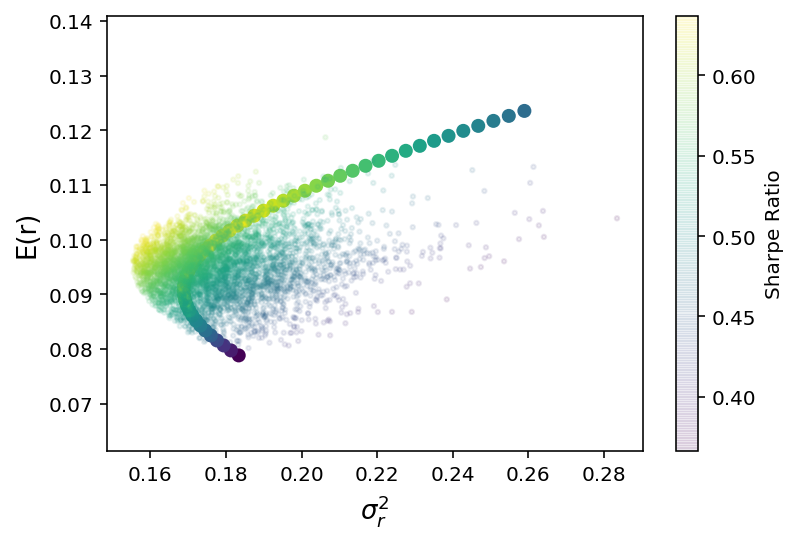

In [22]:
r_opt = []
v_opt = []

for w in pesos_optimos:
    r_opt.append(port_rend(w,rend))
    v_opt.append(port_vol(w,rend))

r_opt = np.array(r_opt)
v_opt = np.array(v_opt)

plt.scatter(v_opt,r_opt, c= r_opt/v_opt)
plt.scatter(vol_sim, rend_sim, c=sharpe_ratio, alpha = 0.1, s=5)
plt.colorbar(label="Sharpe Ratio",)
plt.xlabel(r"$\sigma^2_r$", fontsize=13)
plt.ylabel("E(r)",fontsize=13);

In [23]:
#Genero el mismo portafolio pero garantizando que no haya ventas en corto

pesos_optimos1 = []
N, M = rend.shape
w_opt1 = np.random.randn(M)

for e in rend_maxs:
    constraints = [
        {"type": "eq", "fun": sum_weights},
        {"type": "eq", "fun": lambda w_opt1: rend_esperado(w_opt1,e)},
        {"type": "ineq", "fun": lambda w_opt: min_per(w_opt,1)},
        {"type": "ineq", "fun": lambda w_opt: max_per(w_opt,0)},
        {"type": "ineq", "fun": neg_weigts}
    ]

    
    port_opt1 = minimize(port_vol, w_opt1,  constraints = constraints, args=rend)
    w_opt1 = port_opt1.x
    pesos_optimos1.append(w_opt1)
    
pesos_optimos1

[array([-0.00249352,  0.37183174, -0.00249352,  0.02167433,  0.61148097]),
 array([1.30004186e-02, 3.35300563e-01, 3.69257337e-20, 6.13278346e-02,
        5.90371184e-01]),
 array([1.80047372e-17, 3.00000000e-01, 1.69324292e-02, 3.36217928e-01,
        3.46849643e-01]),
 array([0.01246805, 0.3       , 0.02925971, 0.32522075, 0.33305148]),
 array([0.03168957, 0.3       , 0.03195121, 0.31657832, 0.3197809 ]),
 array([0.05062031, 0.3       , 0.03512922, 0.30716481, 0.30708566]),
 array([0.06958175, 0.3       , 0.03828401, 0.29756947, 0.29456476]),
 array([0.08854926, 0.3       , 0.0414357 , 0.2879244 , 0.28209064]),
 array([0.1075182 , 0.3       , 0.04458684, 0.2782658 , 0.26962916]),
 array([0.12648752, 0.3       , 0.04773785, 0.26860351, 0.25717112]),
 array([0.14545696, 0.3       , 0.0508888 , 0.25894018, 0.24471405]),
 array([0.16442642, 0.3       , 0.05403977, 0.24927652, 0.2322573 ]),
 array([0.1833959 , 0.3       , 0.05719072, 0.23961272, 0.21980067]),
 array([0.20236538, 0.3      

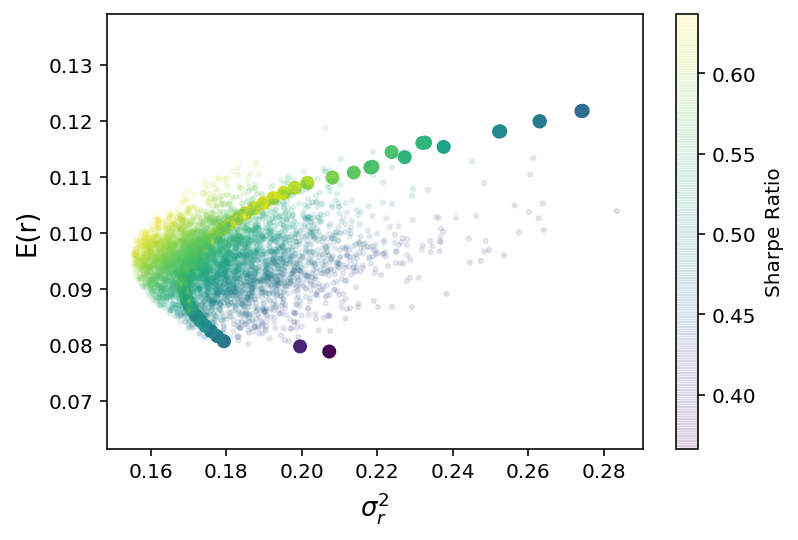

In [24]:
r_opt1 = []
v_opt1 = []

for w in pesos_optimos1:
    r_opt1.append(port_rend(w,rend))
    v_opt1.append(port_vol(w,rend))

r_opt1 = np.array(r_opt1)
v_opt1 = np.array(v_opt1)

plt.scatter(v_opt1,r_opt1, c= r_opt1/v_opt1)
plt.scatter(vol_sim, rend_sim, c=sharpe_ratio, alpha = 0.1, s=5)
plt.colorbar(label="Sharpe Ratio",)
plt.xlabel(r"$\sigma^2_r$", fontsize=13)
plt.ylabel("E(r)",fontsize=13);

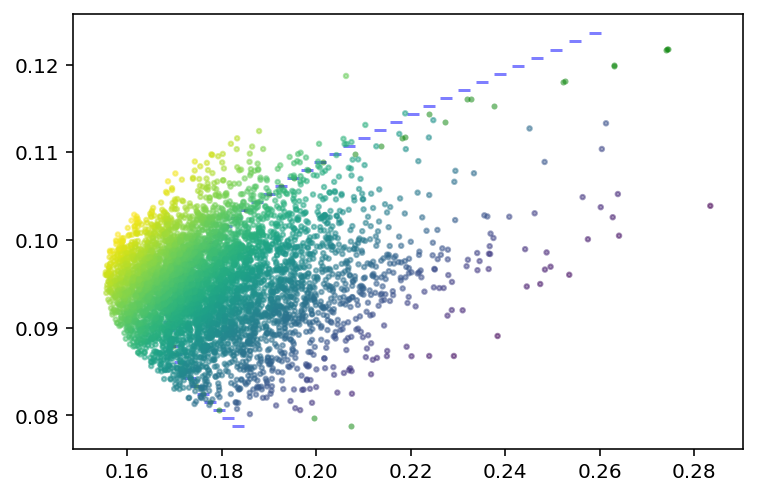

In [25]:
#Grafica ambas fronteras
plt.scatter(v_opt,r_opt, c= "blue",linewidths=1,alpha=.5,marker = "_")
plt.scatter(v_opt1,r_opt1, c= "green",linewidths=.01,alpha=.5,marker = ".")
plt.scatter(vol_sim, rend_sim, c=sharpe_ratio, alpha = 0.5, s=5)

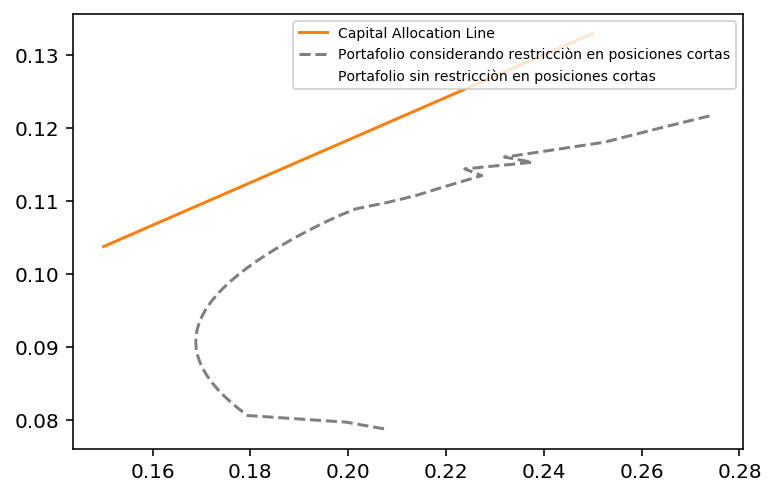

In [26]:
#Genero la CAL junto con su gràfica
rf = 0.06
w0 = np.random.randn(M)

def min_func_sharpe(weights):
    return - (port_rend(weights, rend) - rf)/port_vol(weights,rend)

constraints2 = [
    {"type": "eq","fun":sum_weights}
]

f_sharpe = minimize(min_func_sharpe,w0, constraints = constraints2)
w_sharpe = f_sharpe.x
e_sharpe = port_rend(w_sharpe,rend)
vol_sharpe = port_vol(w_sharpe, rend)

sigma_c = np.linspace(.15,0.25)
sharpe = rf + sigma_c * (e_sharpe - rf) / vol_sharpe

plt.plot(sigma_c,sharpe, linestyle = "-", c= "tab:orange",label = "Capital Allocation Line")
plt.plot(v_opt1,r_opt1, linestyle = "--", c= "tab:gray",label = "Portafolio considerando restricciòn en posiciones cortas")
plt.plot(v_opt,r_opt,linestyle = "",marker="",markersize=5.0, c= "tab:red",label = "Portafolio sin restricciòn en posiciones cortas")
plt.legend(fontsize=7, loc ='upper right' )